## **Objective: Build a forecast which predicts the sales of champagne in the future.**


The general process for solving the problem is the following:

* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts for P and Q lags
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Time Series Modelling/perrin-freres-monthly-champagne.csv')
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [ ]:
data.shape

(107, 2)

In [ ]:
# Rename the columns name
data = data.rename(columns = {'Perrin Freres monthly champagne sales millions ?64-?72':'Sales'})

In [ ]:
# Checking for null values
data.isnull().sum()

Month    1
Sales    2
dtype: int64

In [ ]:
data.dropna(inplace = True)

In [ ]:
data.isnull().sum()

Month    0
Sales    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


**Observations:**
* The month column is not of datetime format, so convert it into date time.


In [ ]:
data['Month'] = pd.to_datetime(data['Month'])

In [ ]:
# set index as month
data.set_index('Month', inplace = True)

In [ ]:
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


### **Visualizing the data**

Text(0, 0.5, 'Number of Champagne sales')

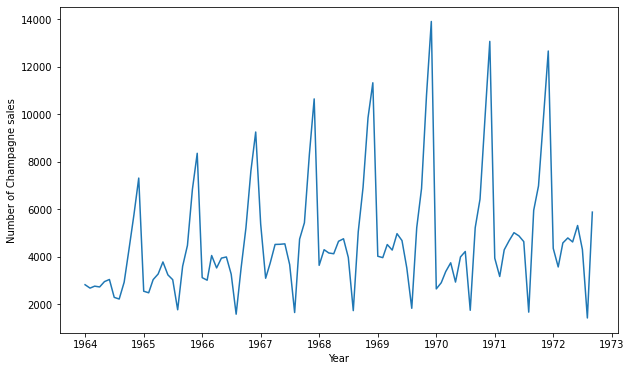

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(data)
plt.xlabel('Year')
plt.ylabel('Number of Champagne sales')

**Observations:**
* From the above plot it is very clear that the sales of champagne is seasonal.

## **Let's check whether the data is Staionary or not**

In [ ]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def test_stationarity(timeseries):
  
  # determining rolling statistics
  movingAvg = timeseries.rolling(window = 12).mean()
  movingStd = timeseries.rolling(window = 12).std()

  #plotting rolling statistics
  plt.figure(figsize=(10,6))
  plt.plot(timeseries, label = 'Original data', color = 'blue')
  plt.plot(movingAvg, label = 'Moving Average', color = 'red')
  plt.plot(movingStd, label = 'Moving Standard Deviation', color = 'Yellow')
  plt.legend(loc = 'best')
  plt.show()

  # ADCF test
  result = adfuller(timeseries)
  labels = ['ADF Test Statistic','p_value','#lags used','Number of Observations Used']
  for value, label in zip(result, labels):
    print(label +' : ' + str(value))
  
  if result[1] <= 0.05:
    print('Strong evidence against Null Hypothesis(H0), reject the null Hypothesis, Data is stationary')
  else:
    print('Weak evidence against null Hypothesis(H1), accept null Hypothesis, Data is not stationary.')

  



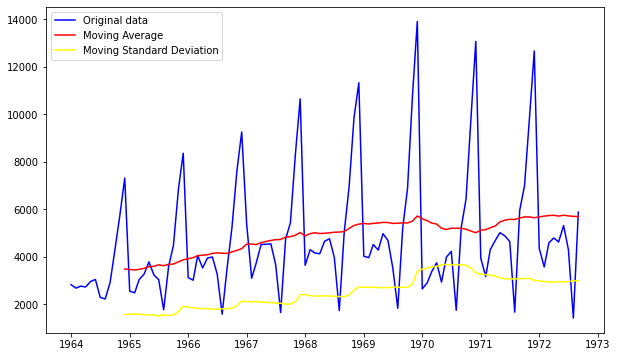

ADF Test Statistic : -1.8335930563276228
p_value : 0.363915771660245
#lags used : 11
Number of Observations Used : 93
Weak evidence against null Hypothesis(H1), accept null Hypothesis, Data is not stationary.


In [ ]:
test_stationarity(data['Sales'])

## **Differencing**
* Since our data looks like seasonal over 12 months. Therefore will will be using 12 differencing.

In [ ]:
data['seasonal_first_difference'] = data['Sales'] - data['Sales'].shift(12)
data.head(20)

,Sales,seasonal_first_difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


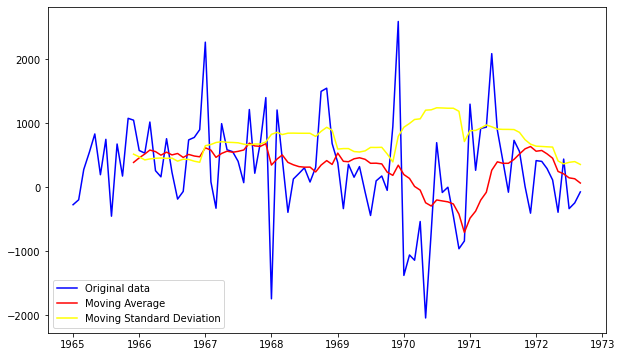

ADF Test Statistic : -7.626619157213164
p_value : 2.060579696813685e-11
#lags used : 0
Number of Observations Used : 92
Strong evidence against Null Hypothesis(H0), reject the null Hypothesis, Data is stationary


In [ ]:
# Remove the null values in seasonal_firts difference
test_stationarity(data['seasonal_first_difference'].dropna())

**Observations:**
* As observed now our p_value is less than 0.05, therefor we reject the null hypothesis. And now our data looks like stationary.

## Plotting acf and pacf graph for calculating the p and q values.

## **Final Thoughts on Autocorrelation and Partial Autocorrelation**
Identification of an AR model is often best done with the PACF.
* For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

* For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q p AR model lags d differencing q MA lags

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

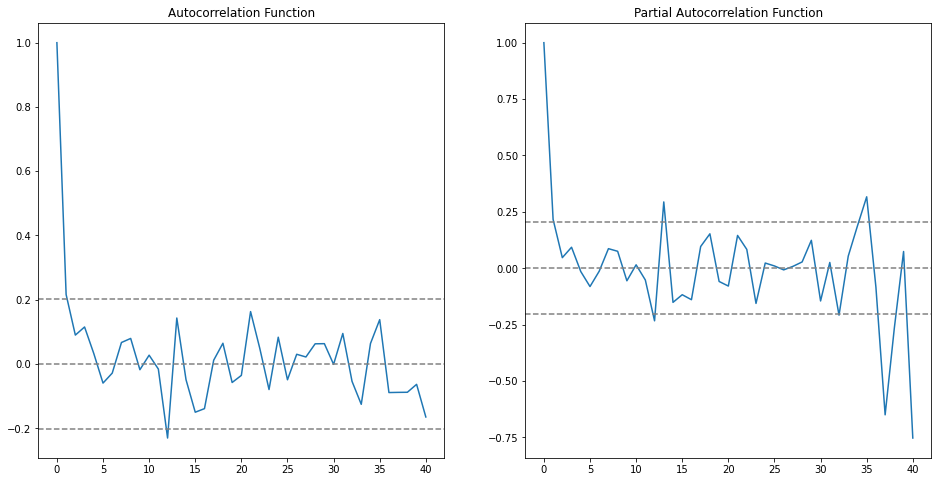

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(data['seasonal_first_difference'].dropna(), nlags = 40)
lag_pacf = pacf(data['seasonal_first_difference'].dropna(), nlags= 40, method = 'ols')

plt.figure(figsize =(16,8))
#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y= -1.96/np.sqrt(len(data['seasonal_first_difference'].dropna())), linestyle = '--', color = 'gray')
plt.axhline(y= 1.96/np.sqrt(len(data['seasonal_first_difference'].dropna())), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y= -1.96/np.sqrt(len(data['seasonal_first_difference'].dropna())), linestyle = '--', color = 'gray')
plt.axhline(y= 1.96/np.sqrt(len(data['seasonal_first_difference'].dropna())), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')

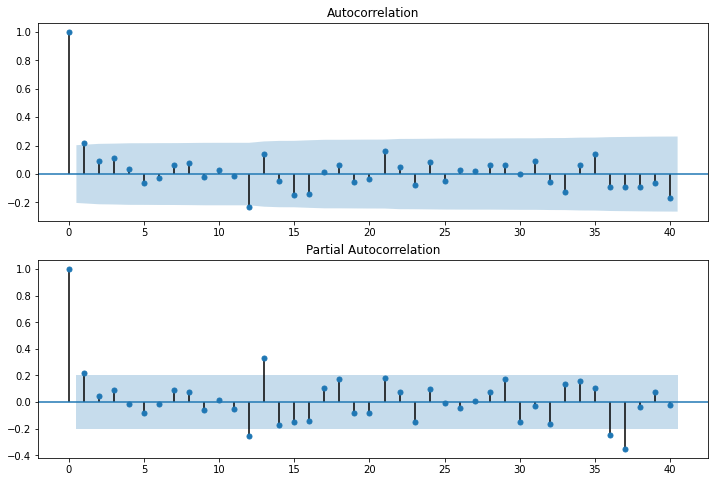

In [ ]:
#Method 2
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize= (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['seasonal_first_difference'].dropna(), lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['seasonal_first_difference'].dropna(), lags = 40, ax = ax2)

### **Observations:**
* There is sudden decrease at 1. So our P and Q values will be 1.

## **ARIMA Model**:
ARIMA model is implemented only when our model is not seasonal.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data['Sales'], order = (1,1,1))
results_AR = model.fit()
results_AR.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Wed, 24 Feb 2021   AIC                           1910.251
Time:                        10:47:32   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7848     12.405      1.837      0.069      -1.529      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

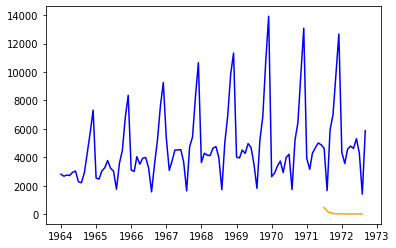

In [ ]:
forecast = results_AR.predict(start = 90, end = 103, dynamic = True)
plt.plot(forecast, color='orange')
plt.plot(data['Sales'],color = 'blue')

* The forecast is not good because we are using ARIMA model for forecasting seasonal data. Let's implement seasonal ARIMA.

## **SARIMA model**

In [ ]:
model = sm.tsa.statespace.SARIMAX(data['Sales'], order = (1,1,1), seasonal_order=(1,1,1,12))
results_SAR = model.fit()
results_SAR.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Wed, 24 Feb 2021   AIC                           1486.804
Time:                                    11:31:40   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

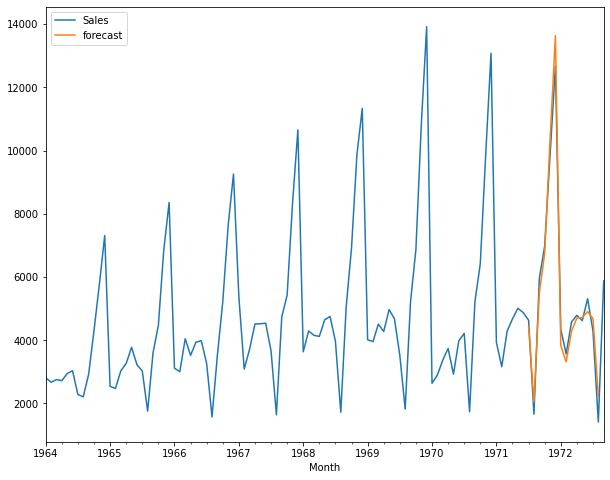

In [ ]:
data['forecast'] = results_SAR.predict(start = 90, end = 103, dynamic = True)
data[['Sales','forecast']].plot(figsize = (10,8))

* ## Let's Create a future dates for 24 months and then predict the sales of champagne for this future dates.

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(months = x)for x in range(0,24)]
future_dates

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_datest_df.head()

,Sales,seasonal_first_difference,forecst,forecast
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN


In [ ]:
future_datest_df.tail()

,Sales,seasonal_first_difference,forecst,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


### **Observations:**
* THe furture dates starts from 1st october 1972- 1st august 1974. At present it contains null values.

* Now let's merge both the dataset original as well as future data.

In [ ]:
future_data = pd.concat([data,future_datest_df])
future_data.head()

,Sales,seasonal_first_difference,forecst,forecast
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,NaN,NaN,NaN
1964-03-01,2755.0,NaN,NaN,NaN
1964-04-01,2721.0,NaN,NaN,NaN
1964-05-01,2946.0,NaN,NaN,NaN


* ## Making predictions for the future dates..

Text(0.5, 1.0, 'RSS: 103795363.8079')

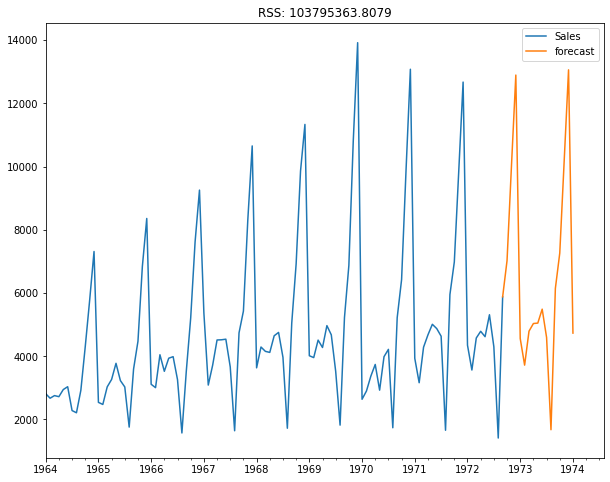

In [ ]:
future_data['forecast'] = results_SAR.predict(start=104, end = 120)
future_data[['Sales','forecast']].plot(figsize = (10,8))
plt.title('RSS: %.4f'%sum((results_SAR.fittedvalues-data['Sales'])**2))

### **Observations:**
* Now we are able to predict the sales of champagne with a very good accuracy.

# **Thank You**